## INSTALLING REQUIRED PACKAGE

In [1]:
!pip install yfinance --quiet

## IMPORTING LIBRARIES

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## DATA COLLECTION

In [3]:
df = yf.download("^GSPC", start="2010-01-01", end="2024-12-31")
df.reset_index(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## EXPLORATORY DATA ANALYSIS (EDA)

Data Head:
Price        Date        Close         High          Low         Open  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
0      2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059   
1      2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034   
2      2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961   
3      2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020   
4      2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020   

Price       Volume  
Ticker       ^GSPC  
0       3991400000  
1       2491020000  
2       4972660000  
3       5270680000  
4       4389590000  

Missing Values:
Price   Ticker
Date              0
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64

Descriptive Stats:
Price                            Date        Close         High          Low  \
Ticker                                       ^GSPC        ^GSPC  

<Axes: title={'center': 'S&P 500 Close Price Over Time'}>

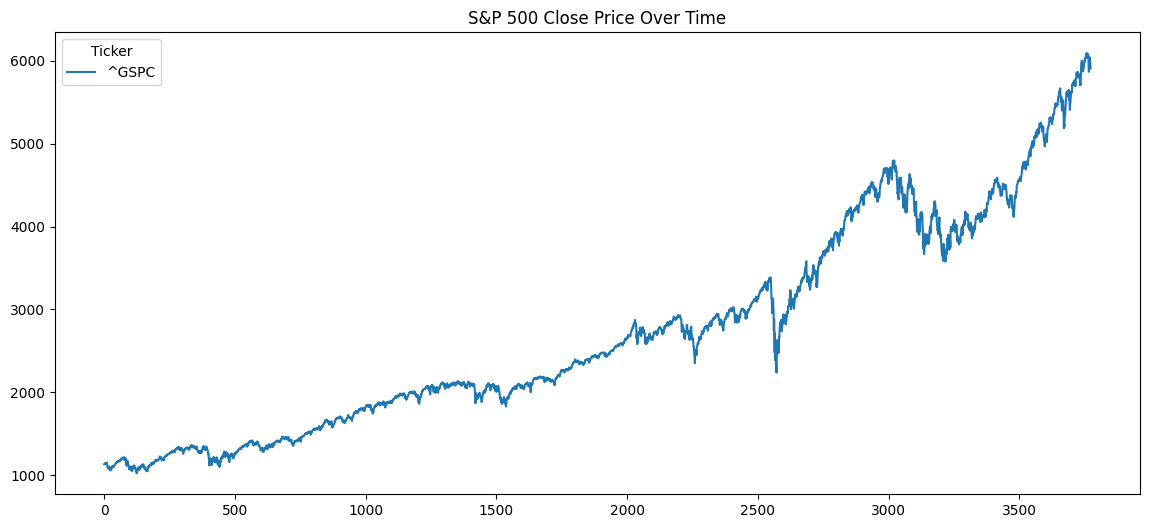

In [4]:
print("Data Head:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDescriptive Stats:")
print(df.describe())
df['Close'].plot(title="S&P 500 Close Price Over Time", figsize=(14, 6))

## PREPROCESSING

In [5]:
df.fillna(method='ffill', inplace=True)
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


<ipython-input-5-90aa5d90f6e0>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## MODELING

In [6]:
# Bagging - Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [7]:
# Boosting - Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [8]:
# Stacking - Combine RF + GB
stack_model = StackingRegressor(
    estimators=[('rf', rf), ('gb', gb)],
    final_estimator=Ridge()
)
stack_model.fit(X_train, y_train)
stack_preds = stack_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## EVALUATION

In [9]:
def evaluate(true, pred, model_name):
    return {
        "Model": model_name,
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE": mean_absolute_error(true, pred),
        "R²": r2_score(true, pred)
    }

results = pd.DataFrame([
    evaluate(y_test, rf_preds, "Random Forest"),
    evaluate(y_test, gb_preds, "Gradient Boosting"),
    evaluate(y_test, stack_preds, "Stacking Ensemble")
])

print("\n📊 Model Performance:")
print(results)



📊 Model Performance:
               Model        RMSE         MAE        R²
0      Random Forest  440.916777  237.263196  0.552418
1  Gradient Boosting  440.675992  238.563710  0.552907
2  Stacking Ensemble  682.333159  636.525868 -0.071895


## Model Training Time Comparison

In [19]:
import time

start_rf = time.time()
RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_time = time.time() - start_rf

start_gb = time.time()
GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
gb_time = time.time() - start_gb

start_xgb = time.time()
XGBRegressor(n_estimators=100).fit(X_train, y_train)
xgb_time = time.time() - start_xgb

print(f"Random Forest Training Time: {rf_time:.2f}s")
print(f"Gradient Boosting Training Time: {gb_time:.2f}s")
print(f"XGBoost Training Time: {xgb_time:.2f}s")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Random Forest Training Time: 4.98s
Gradient Boosting Training Time: 1.73s
XGBoost Training Time: 0.63s


## Cross-Validation for Overfitting Check

In [20]:
from sklearn.model_selection import cross_val_score

cv_score_rf = cross_val_score(rf, X_train, y_train, cv=5).mean()
cv_score_gb = cross_val_score(gb, X_train, y_train, cv=5).mean()
cv_score_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5).mean()

print(f"Cross-Validated Score - RF: {cv_score_rf:.4f}")
print(f"Cross-Validated Score - GB: {cv_score_gb:.4f}")
print(f"Cross-Validated Score - XGB: {cv_score_xgb:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Cross-Validated Score - RF: 0.2874
Cross-Validated Score - GB: 0.2753
Cross-Validated Score - XGB: -0.2067


## VISUALIZATION

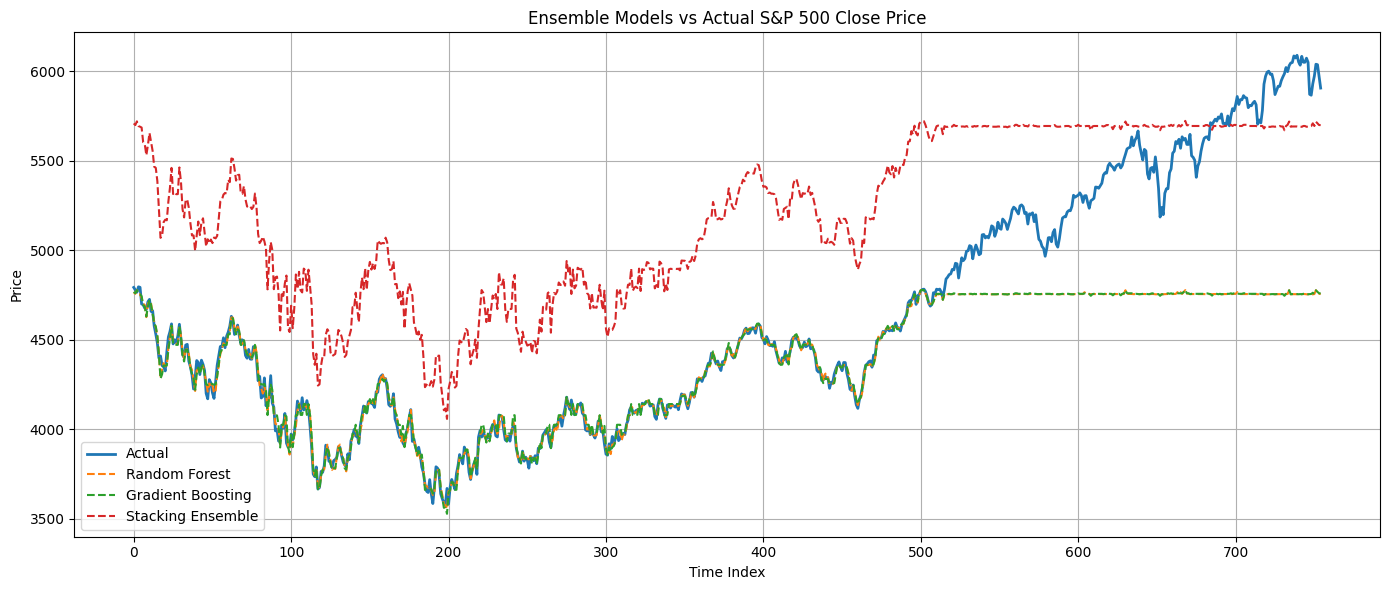

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(rf_preds, '--', label="Random Forest")
plt.plot(gb_preds, '--', label="Gradient Boosting")
plt.plot(stack_preds, '--', label="Stacking Ensemble")
plt.title("Ensemble Models vs Actual S&P 500 Close Price")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare Ensemble Models with Traditional ML

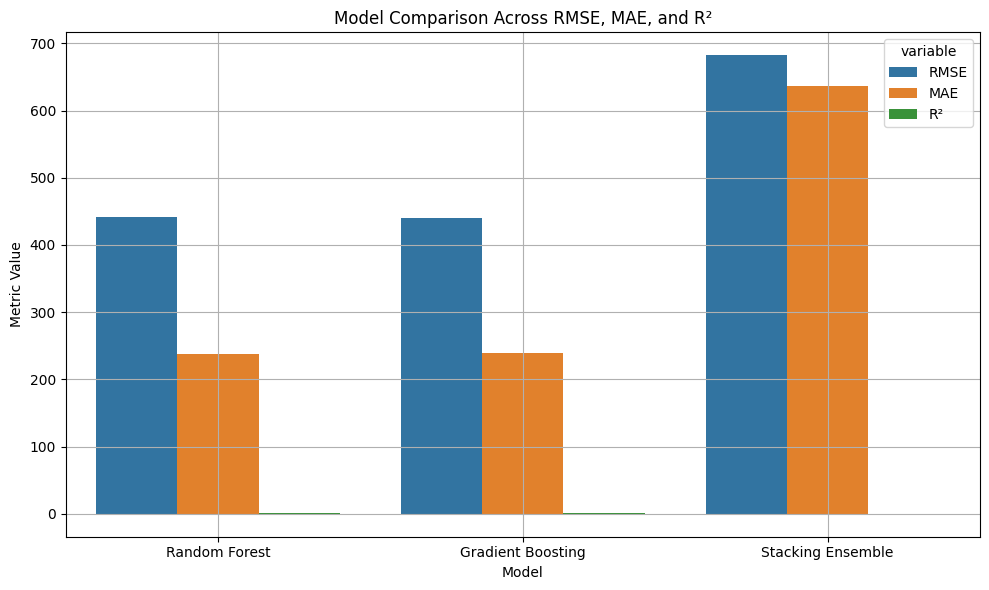

In [12]:
# Compare evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['RMSE', 'MAE', 'R²']
model_names = ['Random Forest', 'Gradient Boosting', 'Stacking']

# Assuming you have `results` DataFrame from previous step
melted = results.melt(id_vars="Model", value_vars=metrics)

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Model", y="value", hue="variable")
plt.title("Model Comparison Across RMSE, MAE, and R²")
plt.ylabel("Metric Value")
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluate Boosting Performance (e.g., XGBoost)

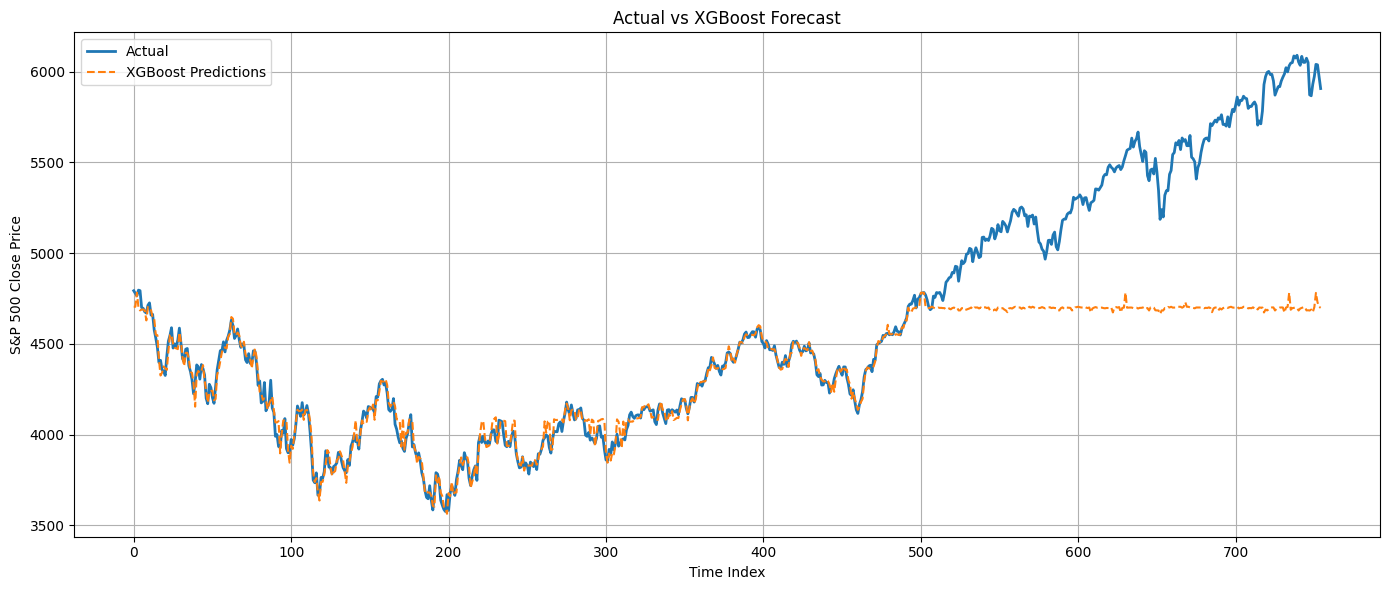

In [13]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(xgb_preds, label="XGBoost Predictions", linestyle='--')
plt.title("Actual vs XGBoost Forecast")
plt.xlabel("Time Index")
plt.ylabel("S&P 500 Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Understand Model Prediction Confidence

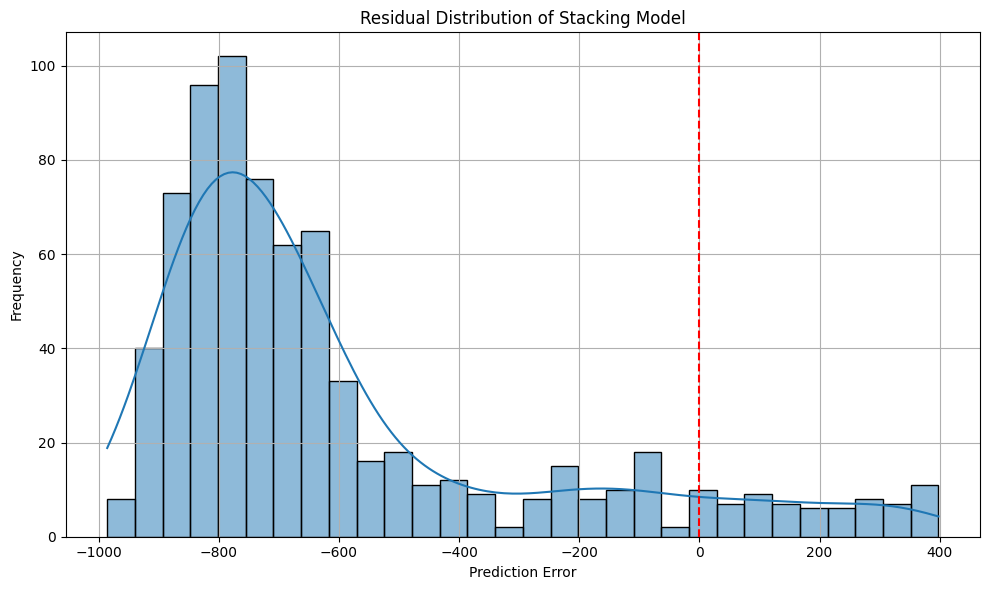

In [18]:
# Ensure y_test is a Series for subtraction
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

# Compute residuals
residuals = y_test.values - stack_preds

# Plot the residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residual Distribution of Stacking Model")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


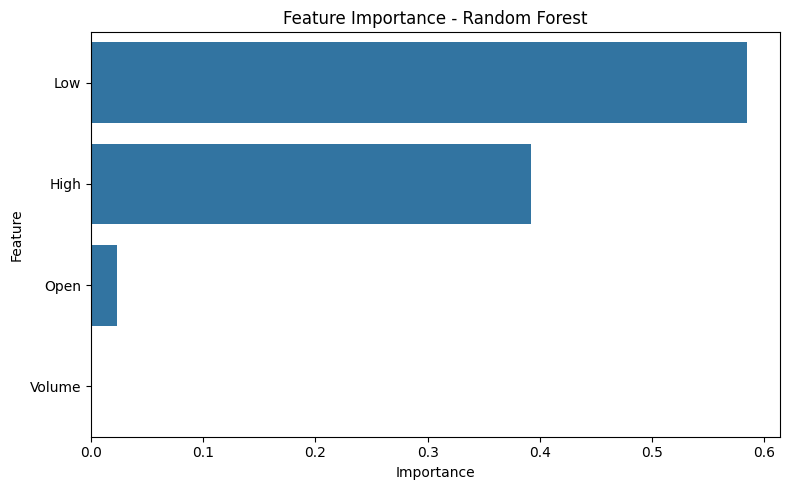

In [17]:
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()
